Creating articifial dataset from MTGSetB (Multi-Touch dataset B) for ER of Untrimmed gestures task.


In [1]:
import math
import os
import random
from typing import List, Tuple
import numpy as np
from skimage.draw import line_aa, line_nd
from utils.parsing import simple_structure_parsing
from matplotlib import pyplot as plt
import tensorflow as tf
import copy

# pathOutputDataset = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\UntrimmedBrutData\\"
pathInputData = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\data\\"
pathOutputImage = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\SeqImage_withValid\\"
pathOutputPreprocess= "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\PreprocessedUntrimmed_withValid\\"
pathOutputPreprocessTest= pathOutputPreprocess+"Test"
pathOutputPreprocessTrain= pathOutputPreprocess+"Train"
pathOutputPreprocessValid= pathOutputPreprocess+"Valid"
separator = "\\"
pathAction = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\\"
actionFileName = "Actions.csv"
if not os.path.exists(pathOutputPreprocess):
    os.mkdir(pathOutputPreprocess)
    os.mkdir(pathOutputPreprocessTest)
    os.mkdir(pathOutputPreprocessValid)
    os.mkdir(pathOutputPreprocessTrain)

In [2]:
f = open(pathAction+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

In [3]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

In [4]:
multiplierCoord = configParams["multiplierCoord"]

def readFileAndAddData(file:str, gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]],multiplierCoord):
    """
    add the gestures of the 'file' in the 'gestures' list
    :param file: the file (.inkml) which contains gestures
    :param gestures: the list to fill with gestures
                    Gesture[             ( Strokes[Points:Tuple[x,y,pressure,time]]    ,className)
                    List    [          Tuple[List[List[Tuple[float,float,float,float]], name]
    :return: void
    """
    gesturesMultiStrokes: List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = simple_structure_parsing(file,multiplierCoord,removeDuplicatedPoint=True)
    gesturesMultiStrokes = list(map(lambda sample : (sample[0],"A_02") if sample[1]=="A_01" else (sample[0],sample[1]),gesturesMultiStrokes))
    #gesture A01 and A02 is the same class
    gestures.extend(gesturesMultiStrokes)

gesturesTrain : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []
gesturesTest : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []
gesturesValid : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []

listFilesTest = os.listdir(pathInputData+"Test")
listFilesTrain = os.listdir(pathInputData+"Train")
print("Testing set")
for fileSample in listFilesTest:
    print(fileSample)
    readFileAndAddData(pathInputData+"Test"+separator+fileSample,gesturesTest,multiplierCoord)

random.seed(10)
random.shuffle(listFilesTrain)
validPart = 0.15
nbForValid = int(validPart*len(listFilesTrain))

listFilesValid = listFilesTrain[:nbForValid]
listFilesTrain = listFilesTrain[nbForValid:]

print("Training set")
for fileSample in listFilesTrain:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.01)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord-0.01)

print(len(gesturesTest))
print(len(gesturesTrain))


for fileSample in listFilesValid:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesValid,multiplierCoord)

Testing set
003.inkml
006.inkml
008.inkml
009.inkml
010.inkml
012.inkml
dell2201_32_002.inkml
dell2202_32_001.inkml
dell2202_32_002.inkml
hp11_32_002.inkml
lenono2701_32_002.inkml
lenono2702_32_001.inkml
lenono2702_32_002.inkml
lenovo2701_46_001.inkml
samsung11_32_002.inkml
samsung11_32_004.inkml
samsung46_32_001.inkml
samsung46_46_001.inkml
Training set
4019
9261


In [5]:
labelsTrain = [cl for _,cl in gesturesTrain]
labelsValid = [cl for _,cl in gesturesValid]
labelsTest = [cl for _,cl in gesturesTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (train set)')

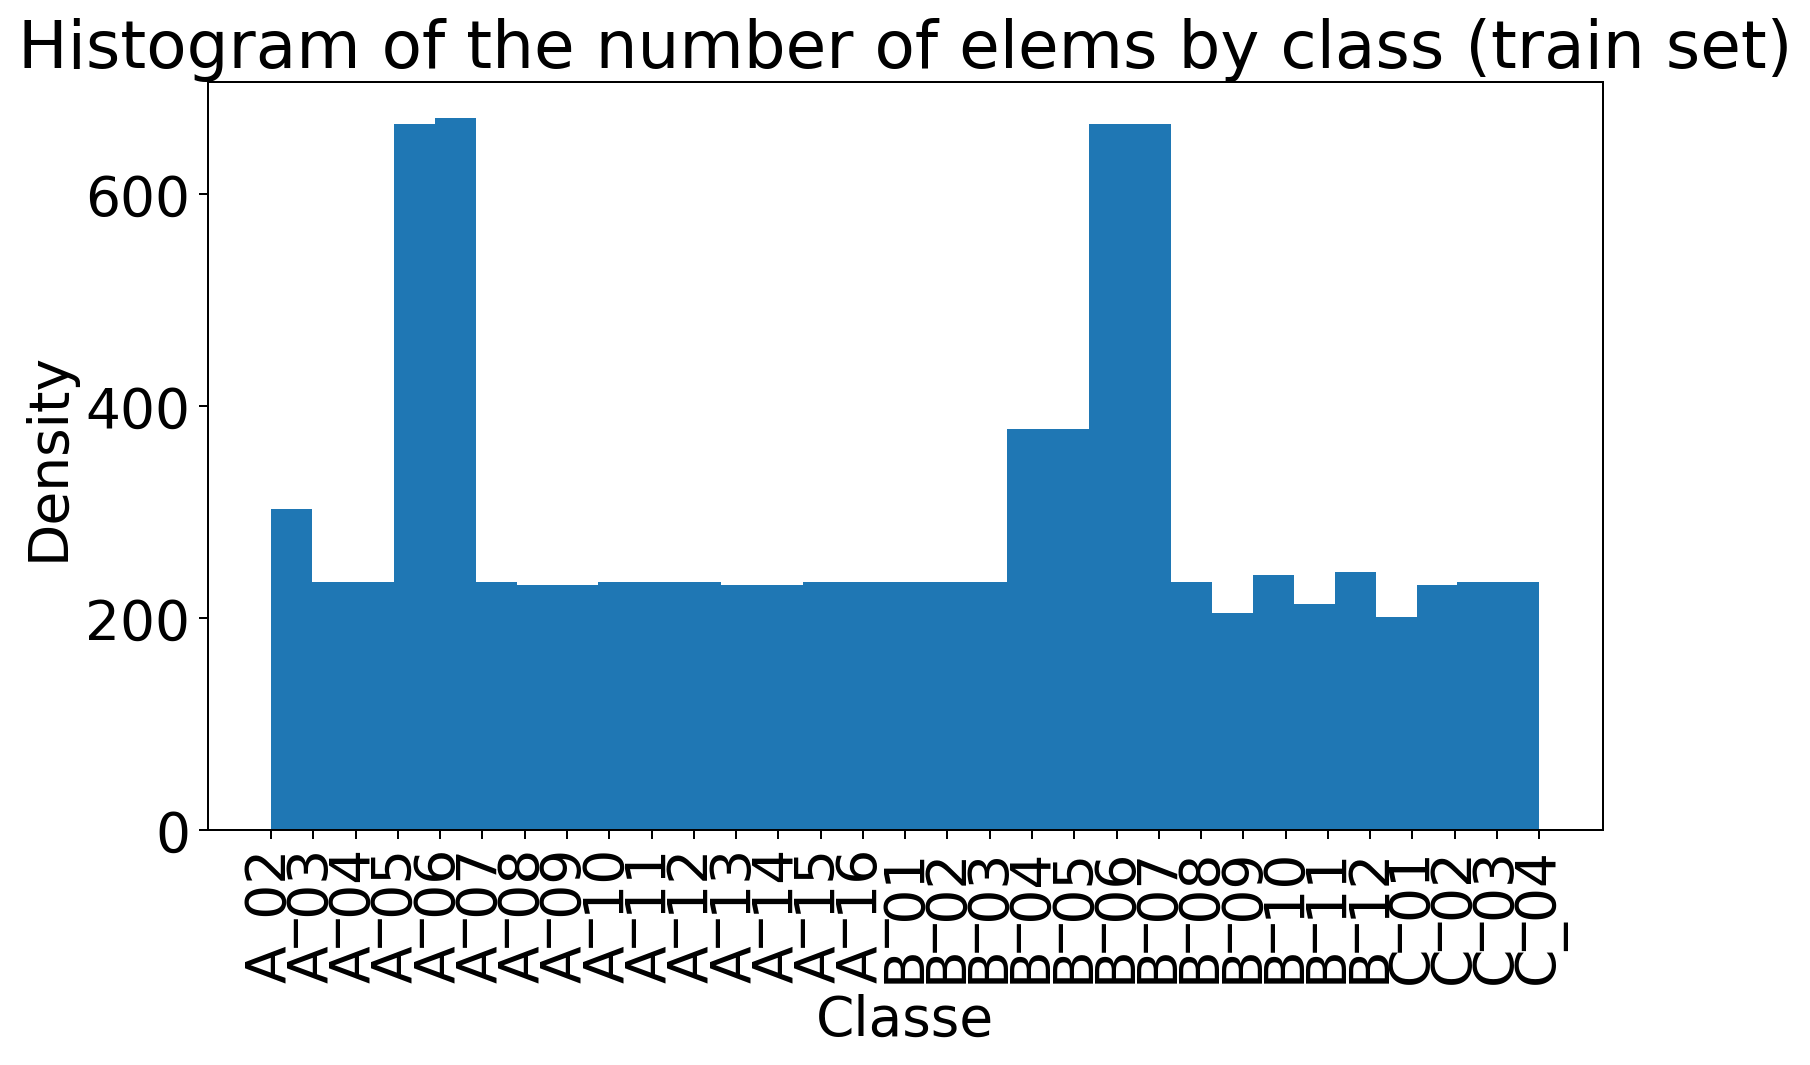

In [6]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)

density, bin, _ = plt.hist(labelsTrain,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (train set)')
# count = [len(gesture[0]) for gesture in gesturesSegmentsTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (test set)')

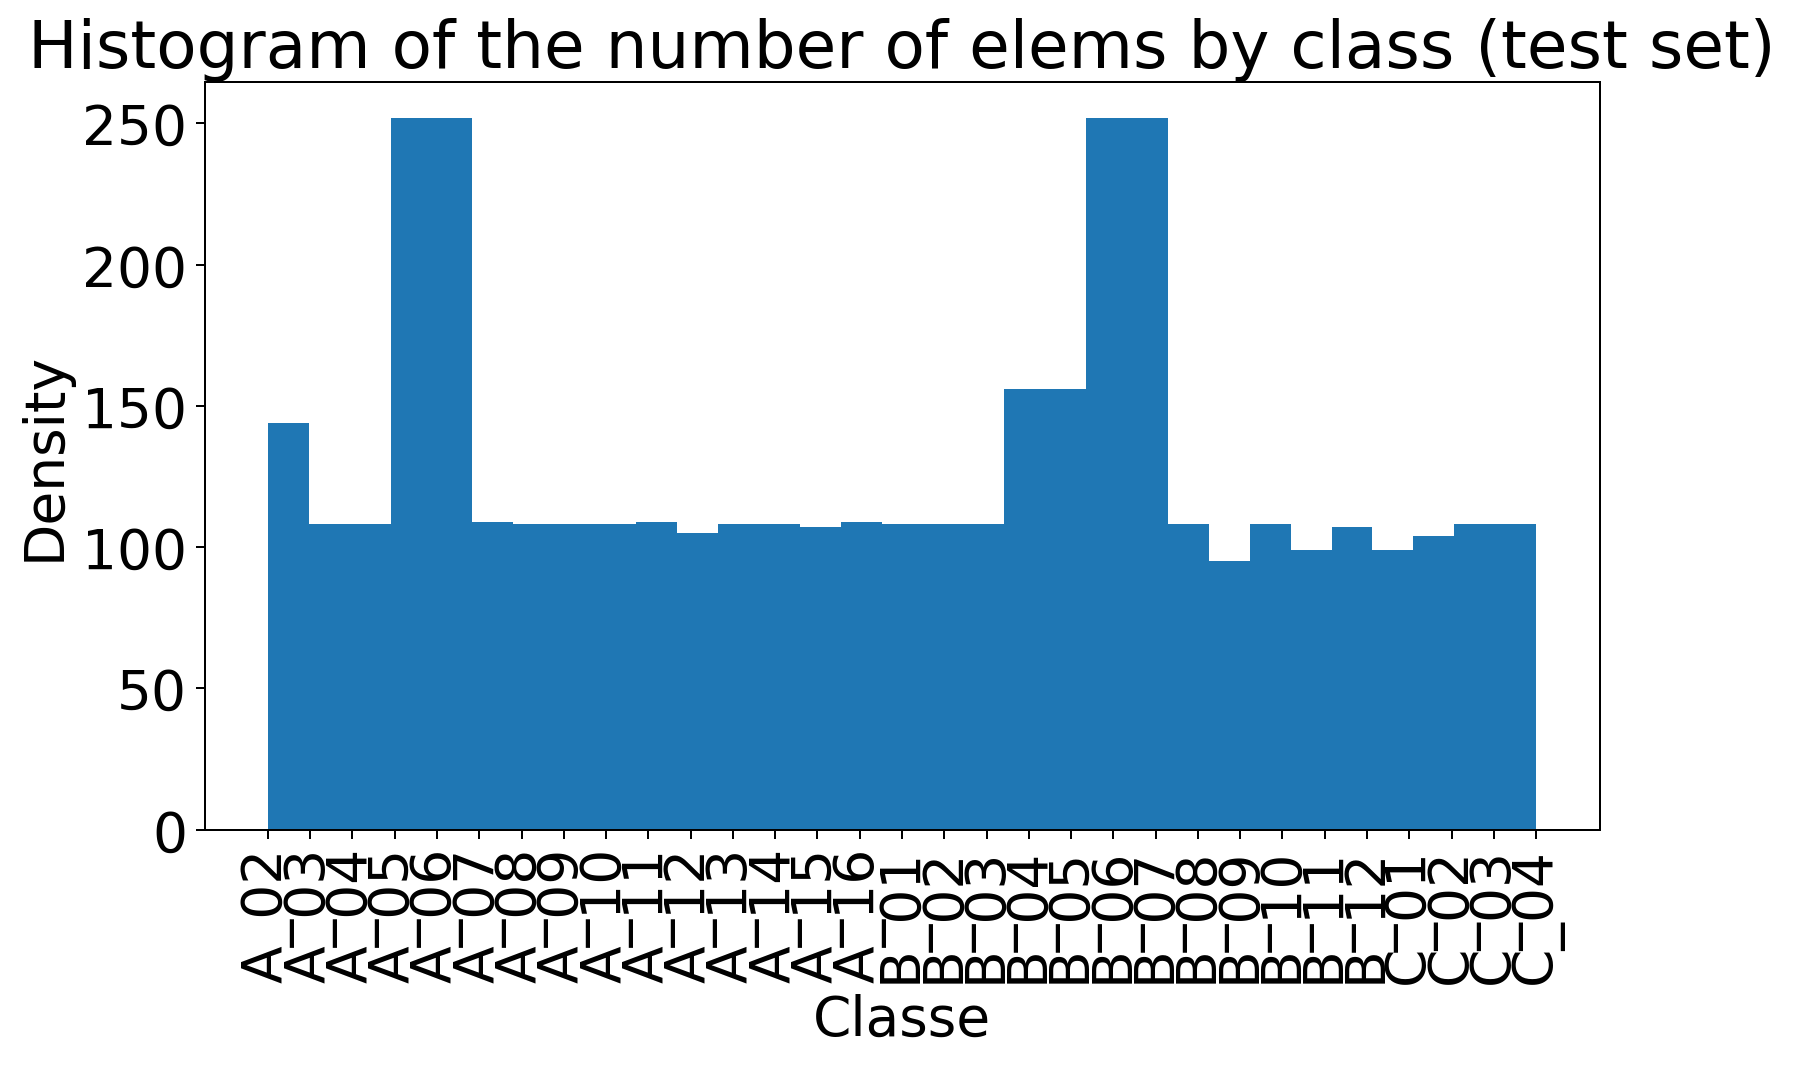

In [7]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)
_, _, _ = plt.hist(labelsTest,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (test set)')

In [8]:
def cumulateGesturesRandomly(gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]],nbGesturePerSequence)->List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]]:
    """

    :param gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]]
    """
    listeOfRemainingIndexes = list(range(0,len(gestures)))
    SequencesOfGestures : List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = []
    while len(listeOfRemainingIndexes)>0:
        lastPointCoord = (0,0)
        nbGesturePerSequenceToUse = random.randint(nbGesturePerSequence-2,nbGesturePerSequence+2)
        segments : List[List[Tuple[float,float,float,float]]] = []
        classNameStartEndStrokes:List[Tuple[str,int,int]] = []

        timeMax = 0
        i=0
        while i<nbGesturePerSequenceToUse and len(listeOfRemainingIndexes)>0:
            indexChosen =  random.randint(0,len(listeOfRemainingIndexes)-1)
            gestureIndex = listeOfRemainingIndexes[indexChosen]
            offset = gestures[gestureIndex][0][0][0][0]-lastPointCoord[0],\
                     gestures[gestureIndex][0][0][0][1]-lastPointCoord[1] #compute the offset to link two gestures

            listeOfRemainingIndexes.remove(gestureIndex)
            classNameStartEndStrokes += [(gestures[gestureIndex][1],len(segments),len(segments)+len(gestures[gestureIndex][0])-1)]
            gestSegmentsCopy = copy.deepcopy(gestures[gestureIndex][0])
            segments += gestSegmentsCopy

            timeMaxNextTime=0
            for seg in gestSegmentsCopy: # seg[0] : List[List[Tuple[float,float,float,float]]]
                for idd,p in enumerate(seg):
                    seg[idd] = (seg[idd][0]-offset[0],seg[idd][1]-offset[1],seg[idd][2],seg[idd][3]+timeMax)
                    lastPointCoord = seg[idd][0],seg[idd][1]

                time = seg[-1][3]
                timeMaxNextTime = time if time>timeMaxNextTime else timeMaxNextTime

            timeMax = timeMaxNextTime+15
            i+=1
        SequencesOfGestures.append((segments, classNameStartEndStrokes))
    return SequencesOfGestures

In [9]:
random.seed(5)

gesturesTest:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = cumulateGesturesRandomly(gesturesTest,6)
gesturesValid:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = cumulateGesturesRandomly(gesturesValid,6)

gestureTrainFinal:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = []
gestureTrainFinal += cumulateGesturesRandomly(gesturesTrain,6)
gestureTrainFinal += cumulateGesturesRandomly(gesturesTrain,6)
gesturesTrain = gestureTrainFinal
print(len(gesturesTest))
print(len(gesturesValid))
print(len(gesturesTrain))

672
97
3076


In [10]:
print(gestureTrainFinal[0][0][-1][-1][0])
print(gestureTrainFinal[1])

-40.08
([[(0.0, 0.0, 60.0, 0.0), (0.0, 0.0, 60.0, 16.0), (0.0, 0.0, 60.0, 17.0), (-0.03999999999999915, 0.0, 60.0, 33.0), (-0.03999999999999915, 0.0, 60.0, 34.0), (-0.03999999999999915, 0.0, 60.0, 91.0), (-0.0799999999999983, 0.0, 60.0, 107.0), (-0.0799999999999983, 0.0, 60.0, 108.0), (-0.11999999999999744, 0.0, 60.0, 111.0), (-0.1599999999999966, 0.0, 60.0, 113.0), (-0.19999999999999574, 0.0, 60.0, 114.0), (-0.3200000000000003, 0.0, 60.0, 115.0), (-0.3999999999999986, 0.0, 60.0, 116.0), (-0.4799999999999969, 0.0, 60.0, 117.0), (-0.5999999999999943, -0.040000000000000924, 60.0, 119.0), (-1.0799999999999983, 0.0, 60.0, 130.0), (-1.279999999999994, 0.0, 60.0, 131.0), (-1.519999999999996, 0.0, 60.0, 142.0), (-1.759999999999998, 0.03999999999999915, 60.0, 143.0), (-2.3200000000000003, 0.08000000000000007, 60.0, 157.0), (-2.6399999999999935, 0.11999999999999922, 60.0, 158.0), (-3.279999999999994, 0.2400000000000002, 60.0, 176.0), (-3.6399999999999935, 0.3200000000000003, 60.0, 177.0), (-4.0

## Put each gesture in little pieces of fixed length

In [11]:
thresholdCuDi = configParams["thresholdCuDi"]*multiplierCoord
def segmentGestureInPiecesOfMovement(gesture:List[List[Tuple[float,float,float,float]]],
                                     labels:List[Tuple[str,int,int]],
                                     thresholdCuDi,debug:bool) -> Tuple[List[List[List[np.ndarray]]],List[str],List[Tuple[int,int,int]]]:
    """
    :param gesture: Strokes[Points[Tuple[x,y,pressure,time]]
    :return:List[List[Strokes[array[x,y]]],
    [
        Segment1:[  Stroke1:[Point1,Point2], Stroke2:[Point3,Point4]
        ],
        Segment2:[Stroke1:[Point5,Point8], Stroke2:[Point,Point]
        ],....

    ]

    And
    [
        segment1Class,
        segment2Class,
        segment3Class,...
    ]
    """


    def remodelingStrokesInOneOrderedByTimeWithStrokeID(gesture:List[List[Tuple[float,float,float,float]]])\
            ->Tuple[List[Tuple[float,float,float,float]],int]:
        """

        :param gesture: Strokes[Points[Tuple[x,y,pressure,time]]
        :return:List[Tuple[x,y,time,strokeID], ordered by time and the number of strokes
        """
        newListOrderedByTime:List[Tuple[float,float,float,float]] = []
        for idStroke,stroke in enumerate(gesture):
            pointsWithStrokeId = list(map(lambda point: (point[0],point[1],point[3],idStroke),stroke))
            newListOrderedByTime += pointsWithStrokeId # concat list

        newListOrderedByTime.sort(key=lambda point:point[2]) #sort by time
        # print("newListOrderedByTime",newListOrderedByTime)
        return newListOrderedByTime,len(gesture)

    gesture, nbStrokes = remodelingStrokesInOneOrderedByTimeWithStrokeID(gesture)


    currentCuDi = 0
    currentIndexStroke = 0

    pieces :        List[List[List[np.ndarray]]] = []
    piecesClass :   List[str] = []
    currentListOfStrokesPoint:List[List[np.ndarray]] = [[] for _ in range(nbStrokes)]
    previousPoint = [0]*nbStrokes
    cptStrokeBeginClass = 0
    cptStrokeCurrent = 0
    lastStartEnd = (labels[0][1],labels[0][2])
    lastLab = labels[0][0]
    class_start_end_pieces:List[Tuple[int,int,int]] = []
    currentStrokesBeingDrawn = set()
    while currentIndexStroke<len(gesture):
        poin = gesture[currentIndexStroke]
        if debug:
            print("currentIndexStroke",currentIndexStroke,"poin[0:2]",poin[0:2])
            print("previousPoint[indexStrokeTmp]",previousPoint[poin[3]])

        timeCurrentPoint = poin[2]

        if(currentIndexStroke+1<len(gesture)):
            poinAft = gesture[currentIndexStroke+1]
            if poin[2]==poinAft[2] and poin[3]==poinAft[3]: # time and stroke
                currentIndexStroke+=1
                continue # if the next point is at the same time and same stroke, we take le next one, so next loop

        totalCuDiAtThisTime = 0
        pointsToDoSameTime = [] # should contains at most one point by stroke
        while currentIndexStroke<len(gesture): # to get all the points which have been done at the same time
            pointTmp = np.array(gesture[currentIndexStroke])
            timeTmp = pointTmp[2]

            if(timeCurrentPoint!=timeTmp): # the list is ordered by time
                break
            pointsToDoSameTime.append(pointTmp)
            coordTmp, indexStrokeTmp = pointTmp[0:2], int(pointTmp[3])
            prevPoint = previousPoint[indexStrokeTmp]
            try:
                if(prevPoint == 0): # will raise a ValueError if it's a np.array
                    # print("prevpoint is 0")
                    previousPoint[indexStrokeTmp] = coordTmp
                    prevPoint = coordTmp
            except ValueError: # prevpoint is really a point
                pass
            # print("coordTmp,prevPoint",coordTmp,prevPoint)
            # print("coordTmp-prevPoint",coordTmp-prevPoint)
            normDiff = np.linalg.norm(coordTmp-prevPoint)
            # print("normDiff",normDiff)
            totalCuDiAtThisTime += normDiff
            currentIndexStroke += 1
        currentIndexStroke -= 1


        # print("len(pointsToDoSameTime)",len(pointsToDoSameTime))
        newPointsToDoSameTime = []
        indexStrokeAlreadySelected = [] # contains the strokes ids of points which will be drawn

        # we keep only one value for each strokes at the same time (the last one)
        # this shouldnt happen, but it does in the data
        for i in range(len(pointsToDoSameTime)-1,-1,-1): # reversed loop to take the last point
            if pointsToDoSameTime[i][3] not in indexStrokeAlreadySelected:
                indexStrokeAlreadySelected.append(pointsToDoSameTime[i][3])
                newPointsToDoSameTime.append(pointsToDoSameTime[i])
        newPointsToDoSameTime.reverse() # on place
        pointsToDoSameTime = newPointsToDoSameTime
        assert len(pointsToDoSameTime) <= nbStrokes # was not always true because we have 808 493 60 35, 808 492 60 35, for the same stroke in data



        #if any stroke has been drawn before (if not all fingers have been up)
        # then continue the gesture
        toClear = False # if not, then separate the strokes into differents pieces
        # print("current indexes being drawn",currentStrokesBeingDrawn)
        # print("indexStrokeAlreadySelected ",indexStrokeAlreadySelected)
        #<10 because some strokes are unstable, can be reduced
        if len(currentStrokesBeingDrawn)==0 or \
            timeCurrentPoint-oldTimeCurrentPoint<10 or \
            any([indexStroke in currentStrokesBeingDrawn for indexStroke in indexStrokeAlreadySelected]):
            currentStrokesBeingDrawn = currentStrokesBeingDrawn.union(indexStrokeAlreadySelected)

        else :
            currentStrokesBeingDrawn = set(indexStrokeAlreadySelected)
            toClear = True


        # all the points in pointsToDoSameTime have been done in the same time, they all need to be in the same segment
        # if it is over the treshold we interpolate for each point a new point

        # 1) threshold reached almost perfectly or 2) over or 3)ToClear=True <=> all fingers have been up just before
        if abs(currentCuDi+totalCuDiAtThisTime-thresholdCuDi)<0.00001 or \
                currentCuDi+totalCuDiAtThisTime>=thresholdCuDi or \
                toClear :
            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke].append(p[0:2])
            indexStroke = int(pointsToDoSameTime[0][3])
            currentCuDi = 0
            pieces.append(currentListOfStrokesPoint)
            piecesClass.append(actions.index(lastLab))
            lab = [labels[i][0] for i,(cl,start,end) in enumerate(labels) if start<=indexStroke<=end]
            labStartEnd = [(start,end) for i,(cl,start,end) in enumerate(labels) if start<=indexStroke<=end]
            assert len(lab)==1
            lab = lab[0]
            labStartEnd = labStartEnd[0]


            if toClear:
                pieces.append(None)
                piecesClass.append(actions.index(lastLab))
                # print("clear cptstorke",cptStrokeCurrent)
                cptStrokeCurrent += 1


            if lastStartEnd[0]!=labStartEnd[0] or lastStartEnd[1]!=labStartEnd[1]:#we just change the cl   asse
                class_start_end_pieces.append((lastLab,cptStrokeBeginClass, cptStrokeCurrent))
                cptStrokeBeginClass = cptStrokeCurrent+1
            lastStartEnd = labStartEnd
            lastLab = lab


            cptStrokeCurrent += 1
            currentListOfStrokesPoint = [[] for _ in range(nbStrokes)]

            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke] = [p[0:2]] # add the pooints at starting point of next seg
                previousPoint[indexStroke] = p[0:2]
        else : # currentCuDi+totalCuDiAtThisTime<thresholdCuDi: # threshold not reached yet
            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke].append(p[0:2])
                previousPoint[indexStroke] = p[0:2]
            currentCuDi += totalCuDiAtThisTime

        # else: # over the threshold, in this case we interpolate linearly the 'perfect' (for each stroke) point to reach the threshold
        #     missValueTotal = thresholdCuDi-currentCuDi
        #     intermediatePoints = []
        #     for p in pointsToDoSameTime:
        #         indexStroke = int(p[3])
        #         norm = np.linalg.norm(p[0:2]-previousPoint[indexStroke])
        #         contribution = norm/totalCuDiAtThisTime
        #         print("-----")
        #         # print("norm",norm)
        #         vectorPerfectLength = (p[0:2]-previousPoint[indexStroke])/norm*contribution*missValueTotal \
        #             if norm!=0. else np.array([0.,0])
        #         # print("vectorPerfectLength",vectorPerfectLength)
        #         # print("previousPoint[indexStroke]",previousPoint[indexStroke])
        #         intermediatePoint = previousPoint[indexStroke]+vectorPerfectLength
        #         # print("intermediatePoint",intermediatePoint)
        #         currentListOfStrokesPoint[indexStroke].append(intermediatePoint)
        #         intermediatePoints.append(intermediatePoint)
        #     currentCuDi = 0
        #     pieces.append(currentListOfStrokesPoint)
        #     currentListOfStrokesPoint = [[] for _ in range(nbStrokes)]
        #     for i,p in enumerate(pointsToDoSameTime):
        #         indexStroke = int(p[3])
        #         currentListOfStrokesPoint[indexStroke] = [intermediatePoints[i]] # add the pooints at starting point of next seg
        #         previousPoint[indexStroke] = intermediatePoints[i]
        #     currentIndexPoint = oldCurrentIndex - 1 # to do the loop on the same 'coords' points which is not reached yet
        #     # print("return to ",currentIndexPoint+1)
        oldTimeCurrentPoint = timeCurrentPoint
        currentIndexStroke+=1

    # if there is some point at the end where the segments sum doesn't reach the threshold
    # we add them as another piece
    if any(list(map(lambda l: len(l)>0,currentListOfStrokesPoint))):
        pieces.append(currentListOfStrokesPoint)
        notEmptyId = [i for i in range(len(currentListOfStrokesPoint)) if len(currentListOfStrokesPoint[i])>0]
        assert len(notEmptyId)>0
        indexStrokeN = notEmptyId[0]
        lab = [labels[i][0] for i,(cl,start,end) in enumerate(labels) if start<=indexStrokeN<=end]
        assert len(lab)==1
        lab = lab[0]
        lastLab = lab
        piecesClass.append(actions.index(lab))
        class_start_end_pieces.append((lab,cptStrokeBeginClass, cptStrokeCurrent))
        # print("passed here ")
    pieces.append(None)
    piecesClass.append(actions.index(lastLab))
    lastClassStartEnd = class_start_end_pieces[-1]
    class_start_end_pieces[-1] = (lastClassStartEnd[0], lastClassStartEnd[1],lastClassStartEnd[2]+1)
    assert len(pieces) == len(piecesClass)
    # print(lastClassStartEnd[2], len(piecesClass)-1)
    assert lastClassStartEnd[2]+1 == len(piecesClass)-1 #cpt is an index
    return pieces,piecesClass,class_start_end_pieces

In [12]:
gesturesSegmentsTest: List[Tuple[List[List[List[np.ndarray]]],List[str],List[Tuple[int,int,int]]]] = []
gesturesSegmentsValid: List[Tuple[List[List[List[np.ndarray]]],List[str],List[Tuple[int,int,int]]]] = []
gesturesSegmentsTrain: List[Tuple[List[List[List[np.ndarray]]],List[str],List[Tuple[int,int,int]]]] = []
print("Testing set...",)
for i,gesture in enumerate(gesturesTest):
    if (i%500==0):
        print(i,"/",len(gesturesTest))
    gestureSegments: List[List[List[np.ndarray]]]
    gestureClassPerSegment : List[str]
    gestureSegments,gestureClassPerSegment,class_start_end_pieces = segmentGestureInPiecesOfMovement(gesture[0],gesture[1],thresholdCuDi,False)
    gesturesSegmentsTest.append((gestureSegments,gestureClassPerSegment,class_start_end_pieces))
print("Done,",len(gesturesTest),"elements")
print("Training set...")
for i,gesture in enumerate(gesturesTrain):
    if (i%500==0):
        print(i,"/",len(gesturesTrain))
    gestureSegments: List[List[List[np.ndarray]]]
    gestureClassPerSegment : List[str]
    class_start_end_pieces : List[Tuple[int,int,int]]
    gestureSegments,gestureClassPerSegment,class_start_end_pieces = segmentGestureInPiecesOfMovement(gesture[0],gesture[1],thresholdCuDi,False)
    gesturesSegmentsTrain.append((gestureSegments,gestureClassPerSegment,class_start_end_pieces))
print("Done",len(gesturesTrain),"elements")
print("Valid set...")
for i,gesture in enumerate(gesturesValid):
    if (i%500==0):
        print(i,"/",len(gesturesValid))
    gestureSegments: List[List[List[np.ndarray]]]
    gestureClassPerSegment : List[str]
    class_start_end_pieces : List[Tuple[int,int,int]]
    gestureSegments,gestureClassPerSegment,class_start_end_pieces = segmentGestureInPiecesOfMovement(gesture[0],gesture[1],thresholdCuDi,False)
    gesturesSegmentsValid.append((gestureSegments,gestureClassPerSegment,class_start_end_pieces))
print("Done",len(gesturesValid),"elements")

Testing set...
0 / 672
500 / 672
Done, 672 elements
Training set...
0 / 3076
500 / 3076
1000 / 3076
1500 / 3076
2000 / 3076
2500 / 3076
3000 / 3076
Done 3076 elements
Valid set...
0 / 97
Done 97 elements


In [13]:
a = gesturesSegmentsTest[0][0]
print(len(a))
print(a[-1])
print(len(a[-2][0]))

165
None
0


In [14]:
a = gesturesSegmentsTest[1]
print(a[2])
print(a[1])

[('B_04', 0, 28), ('A_06', 29, 46), ('A_08', 47, 65), ('B_06', 66, 82), ('B_07', 83, 92), ('A_06', 93, 108), ('A_07', 109, 126), ('B_06', 127, 140)]
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


### Exploration of the number of segments

(array([  9, 175, 508, 690, 628, 574, 317, 131,  33,  11], dtype=int64), array([ 18. ,  39.2,  60.4,  81.6, 102.8, 124. , 145.2, 166.4, 187.6,
       208.8, 230. ]))


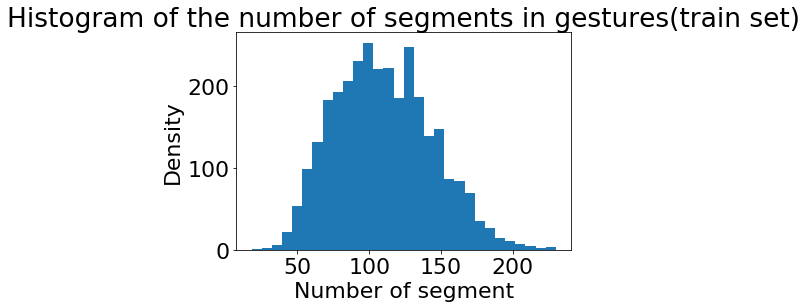

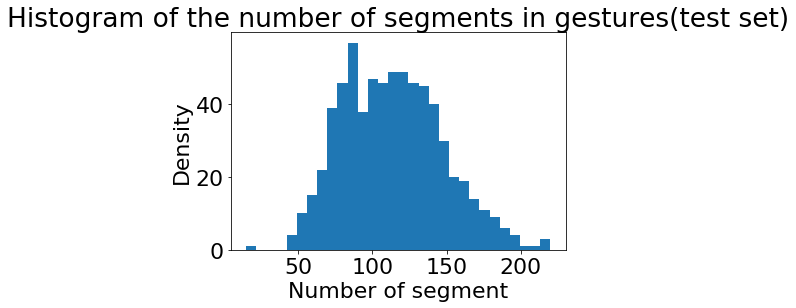

In [15]:
count = [len(gesture[0]) for gesture in gesturesSegmentsTrain]
print(np.histogram(count))
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30,)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(train set)')
count = [len(gesture[0]) for gesture in gesturesSegmentsTest]
plt.savefig("AfterDataAugmentationTrain.png")
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(test set)')
plt.savefig("AfterDataAugmentationTest.png")

## Pixelisation of the gestures along the time

In [16]:
dimensionsOutputImage=np.array([40,40])
def pixelisationOfThePiecesOfGestures(gestureSegments: List[List[List[np.ndarray]]],id:int):
    """

    :param gestureSegments: Segments [ Strokes [ Points [x,y]]]
    :return:
    """
    center = dimensionsOutputImage/2.
    count=0
    gest1 = np.array([0.,0.])
    minX = 99999
    minY = 99999
    maxX = -9999
    maxY = -9999
    for stroke in gestureSegments[0]:
        for idPoint1 in range(0,len(stroke)):
            firstPoint = stroke[idPoint1]
            gest1 += firstPoint[0:2]
            minX = min(minX,firstPoint[0])
            minY = min(minY,firstPoint[1])
            maxY = max(maxY,firstPoint[1])
            maxX = max(maxX,firstPoint[0])
            count+=1
            break
    assert minX!=99999

    offSet = center-gest1/count
    marge = 2
    imagesAlongTime:List[np.ndarray[dimensionsOutputImage]] = [] # len(imagesAlongTime)==len(gestureSegments)
    imagesFingerPosAlongTime:List[np.ndarray[dimensionsOutputImage]] = [] # len(imagesAlongTime)==len(gestureSegments)
    image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
    idSeg=0
    # cpt=0
    # slidingWindowSize = 2

    # currentStrokesBeingDrawn = set()
    while idSeg < len(gestureSegments):
        segment = gestureSegments[idSeg]

        imageLastPoint = np.zeros(shape=dimensionsOutputImage,dtype="bool")
        # idsStrokesNotEmpty = [idStroke for idStroke,stroke in enumerate(segments) if len(stroke)>0]

        # if any([id in currentStrokesBeingDrawn for id in idsStrokesNotEmpty]):
        #     currentStrokesBeingDrawn.union(idsStrokesNotEmpty)
        # else:
        #     imageBlack = np.transpose(np.zeros(shape=dimensionsOutputImage,dtype="bool")) #add a black image at end
        #     imagesAlongTime.append(np.copy(imageBlack))
        #     imagesFingerPosAlongTime.append(np.copy(imageBlack))
        #
        #     image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
        #     currentStrokesBeingDrawn = set(idsStrokesNotEmpty)
        if segment is None: # all fingers have been up from device
            image = np.zeros(shape=dimensionsOutputImage,dtype="bool") #add a black image at end
            imagesAlongTime.append(np.copy(image))
            imagesFingerPosAlongTime.append(np.copy(image))
            idSeg +=1
            continue


        for idStroke,stroke in enumerate(segment):
            for idPoint1 in range(0,len(stroke)-1):
                shifted=False
                idPoint2 = idPoint1+1
                coordP1 = stroke[idPoint1][0:2]+offSet
                coordP2 = stroke[idPoint2][0:2]+offSet
                oldOffset=offSet
                if coordP2[0]>dimensionsOutputImage[0]-marge: # if X > border
                    #shift all the image to left
                    toShift = math.ceil(coordP2[0]-(dimensionsOutputImage[0]-marge))
                       # toShift = min(toShift,dimensionsOutputImage[0]-3)
                    if(toShift>dimensionsOutputImage[0]-marge):
                        coordP2[0] -= (toShift-(dimensionsOutputImage[0]-marge))
                        toShift = math.ceil(coordP2[0]-(dimensionsOutputImage[0]-marge))

                    offSet = offSet-[toShift,0]
                    minX-=toShift
                    shifted = True
                    toShift,axis = -toShift,0
                if coordP2[1]>dimensionsOutputImage[1]-marge:# if Y is < 1
                    toShift = (math.ceil(coordP2[1])-(dimensionsOutputImage[1]-marge))
                    # toShift = min(toShift,dimensionsOutputImage[1]-3)
                    if(toShift>dimensionsOutputImage[1]-marge):
                        coordP2[1] -= (toShift-(dimensionsOutputImage[1]-marge))
                        toShift = math.ceil(coordP2[1]-(dimensionsOutputImage[1]-marge))
                    # if(abs(toShift)>dimensionsOutputImage[1]):
                    #     coordP2[1] = dimensionsOutputImage[1]+dimensionsOutputImage[1]/2
                    #     toShift = math.ceil(coordP2[1]-(dimensionsOutputImage[1]-2))
                    minY-=toShift
                    offSet = offSet-[0,toShift]
                    shifted = True
                    toShift,axis = -toShift,1
                # if <0
                if coordP2[0]<0+marge:
                    toShift = -math.floor(coordP2[0])+marge
                    # toShift = max(toShift,-dimensionsOutputImage[0]+3)
                    if(toShift>dimensionsOutputImage[0]-marge):
                        coordP2[0] -= (dimensionsOutputImage[0]-marge-toShift)
                        toShift = -math.floor(coordP2[0])+marge
                    # if(abs(toShift)>dimensionsOutputImage[0]):
                    #     coordP2[0] = -dimensionsOutputImage[0]/2
                    #     toShift = -math.floor(coordP2[0])+2
                    # if maxX+toShift>dimensionsOutputImage[0]: #overflow case
                    #     print( Exception("Overlflow on right"))
                    maxX+=toShift
                    offSet = offSet+[toShift,0]
                    shifted,axis = True,0
                if coordP2[1]<0+marge:
                    toShift = -math.floor(coordP1[1])+marge
                    # toShift = max(toShift,-dimensionsOutputImage[1]+3)
                    if(toShift>dimensionsOutputImage[1]-marge):
                        coordP2[1] -= (dimensionsOutputImage[1]-marge-toShift)
                        toShift = -math.floor(coordP2[1])+marge
                    # if(abs(toShift)>dimensionsOutputImage[1]):
                    #     coordP2[1] = -dimensionsOutputImage[1]/2
                    #     toShift = -math.floor(coordP2[1])+2
                    maxY+=toShift
                    offSet = offSet+[0,toShift]
                    shifted,axis = True,1
                minX = min(coordP2[0],minX)
                maxX = max(coordP2[0],maxX)
                minY = min(coordP2[1],minY)
                maxY = min(coordP2[1],maxY)
                rr,cc,_ = line_aa(int(round(coordP1[0])),int(round(coordP1[1])),int(round(coordP2[0])),int(round(coordP2[1])))
                try:
                    if shifted:
                        shiftToUseForBlack = toShift
                        if abs(toShift)>dimensionsOutputImage[1]/4:
                            shiftToUseForBlack = int(dimensionsOutputImage[1]//4*abs(toShift)/toShift)  # little trick to avoid weird effect

                        #we put black at the opposite of the image in order to do the roll correctly
                        if axis==0:
                            if toShift > 0:
                                image[-shiftToUseForBlack:]= np.zeros([shiftToUseForBlack,dimensionsOutputImage[1]])
                            else:
                                image[:-shiftToUseForBlack]= np.zeros([-shiftToUseForBlack,dimensionsOutputImage[1]])
                        else:
                            if toShift > 0:
                                image[:,-shiftToUseForBlack:]= np.zeros([dimensionsOutputImage[1],shiftToUseForBlack])
                            else:
                                image[:,:-shiftToUseForBlack]= np.zeros([dimensionsOutputImage[1],-shiftToUseForBlack])
                        #draw segments
                        image[[r%(dimensionsOutputImage[0]) for r in rr],[c%(dimensionsOutputImage[1]) for c in cc]] = 1 # draw the line in the image
                        if (idPoint2==len(stroke)-1):
                            imageLastPoint[rr[-1]%(dimensionsOutputImage[0]),cc[-1]%(dimensionsOutputImage[1])] = 1 # draw the line in the image
                            imageLastPoint = np.roll(imageLastPoint,toShift,axis=axis)
                        #roll image (shift)
                        image = np.roll(image,toShift,axis=axis)
                    else:
                        image[[max(min(r,dimensionsOutputImage[0]-1),0) for r in rr],[max(min(c,dimensionsOutputImage[1]-1),0) for c in cc]] = 1
                        if (idPoint2==len(stroke)-1):
                            imageLastPoint[max(min(rr[-1],dimensionsOutputImage[0]-1),0),max(min(cc[-1],dimensionsOutputImage[1]-1),0)] = 1

                except Exception as e:
                    print("pb ",id)
                    # print(toShift," to shift ")
                    print("max",maxX,maxY,minX,minY)
                    raise e
        imagesAlongTime.append(np.copy(np.transpose(image)))
        imagesFingerPosAlongTime.append(np.copy(np.transpose(imageLastPoint)))
        # image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
        # if cpt==slidingWindowSize:
        #     imagesAlongTime.append(np.copy(np.transpose(image)))
        #     imagesFingerPosAlongTime.append(np.copy(np.transpose(imageLastPoint)))
        #     image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
        #     cpt=0
        #     if idSeg!=0:
        #         idSeg-= (slidingWindowSize-1)
        # cpt+=1
        idSeg += 1
    # imageBlack = np.transpose(np.zeros(shape=dimensionsOutputImage,dtype="bool")) #add a black image at end
    # imagesAlongTime.append(np.copy(imageBlack))
    # imagesFingerPosAlongTime.append(np.copy(imageBlack))
    assert len(imagesAlongTime) == len(imagesFingerPosAlongTime)
    assert len(imagesAlongTime) == len(gestureSegments)
    return imagesAlongTime,imagesFingerPosAlongTime

### One exemple

In [17]:
idToTest  = 0#3431#1607#1578 #1463 # 87 # 1600
segments = gesturesSegmentsTest[idToTest][0]
segmentsClasses = gesturesSegmentsTest[idToTest][1]
firstGesture,firstPenPosGestureAlongTime = pixelisationOfThePiecesOfGestures(segments,idToTest)

In [18]:
print(len(segments))
print(len(segmentsClasses))

165
165


In [19]:
len(firstGesture) #+1 due to black final window

165

<Figure size 432x288 with 0 Axes>

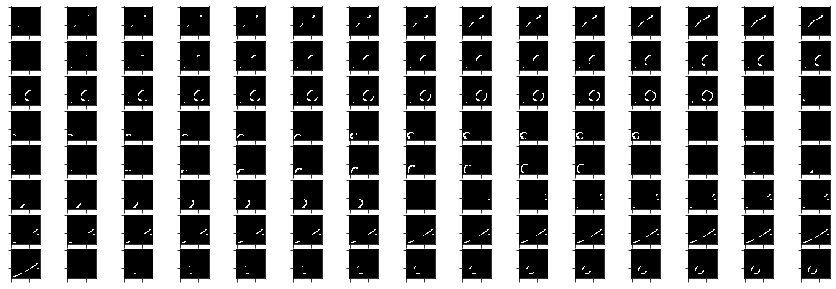

In [20]:
%matplotlib inline
plt.gray()
_, axs = plt.subplots(8, 15, figsize=(15, 5))
axs = axs.flatten()
for img, ax in zip(firstGesture[0:8*15], axs):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img)

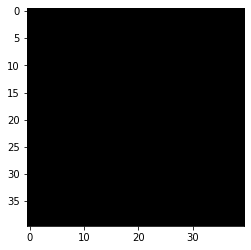

In [21]:
plt.imshow(firstGesture[127]*255, interpolation='nearest')

### Get actions.csv which contains associations between name of class id
format
0;act1
1;act2



### Explore frequency by class

## Store the images in the preprocessed folder

In [22]:
saveImage = True
print("Testing set")
if saveImage:
    try:
        os.mkdir(pathOutputImage)
        os.mkdir(pathOutputImage+"Test")
        os.mkdir(pathOutputImage+"Valid")
        os.mkdir(pathOutputImage+"Train")
    except:
        pass

count = 0
def generatorData(gestureSegmentsAndClasses,folder,isTest=False):
    """

    @param gestureSegments:
    @param folder:
    @return:
    """
    global count
    for i in range(len(gestureSegmentsAndClasses)):
        if(i%100==0 or i==1):
            print(i,"on",len(gestureSegmentsAndClasses))
        classesPerSeq: List[Tuple[str,int,int]]
        gestureSegments, classPerSegment,classesPerSeq = gestureSegmentsAndClasses[i]
        images,fingerPos = pixelisationOfThePiecesOfGestures(gestureSegments,i)
        img = np.expand_dims(images,axis=-1)
        imgFingerPos = np.expand_dims(fingerPos,axis=-1)
        finalImg2Chan = np.concatenate((img,imgFingerPos),axis=-1)

        classes_names = [gest[0] for gest in classesPerSeq]
        classes_indexes = [actions.index(cl) for cl in classes_names]
        classesPerSeq = [(actions.index(cl),s,e) for cl,s,e in classesPerSeq]
        classesPerFrame = np.array(classPerSegment)
        count +=1
        if not isTest:
            yield finalImg2Chan,classesPerFrame,classes_indexes
        else :
            yield finalImg2Chan,classesPerFrame,classes_indexes,classesPerSeq


        # np.save(pathOutputPreprocess+folder+separator+name+".npy",finalImg2Chan)

        if saveImage:
            pathFold = pathOutputImage+folder+separator+str(i)+"_"+"_".join(classes_names)
            os.mkdir(pathFold)
            for id,im in enumerate(img) :
                fing = imgFingerPos[id].astype("uint8")*255
                imCast = im.astype("uint8")*255
                imcolorR = ((imCast+fing)%256).astype("uint8")
                imcolorGB = (imCast-fing).astype("uint8")
                finalImg = np.concatenate((imcolorR,imcolorGB,imcolorGB),axis=-1)
                plt.imsave(pathFold+separator+str(id)+"_"+actions[int(classesPerFrame[id])]+".png",finalImg)

Testing set


In [23]:
genTest = lambda : generatorData(gesturesSegmentsTest,"Test",True)
genValid = lambda : generatorData(gesturesSegmentsValid,"Valid")
genTrain = lambda : generatorData(gesturesSegmentsTrain,"Train")
print("Generators Ready")

Generators Ready


In [24]:
nbClass= len(actions)

In [25]:
def repeatGT(input1, input2, input3):
    #input 2 : [batch seq 1]
    # input2 = tf.reshape(input2,[tf.shape(input2)[0],tf.shape(input2)[1]])
    # input2 = tf.one_hot(input2,nbClass) #[batch,segments,nbClass]
    return input1,(input2[:,tf.newaxis],input2[:,tf.newaxis],input3[:,tf.newaxis])

def getDataset(generator,isTest):
    if not isTest:
        output_shapes = (tf.TensorShape([None, dimensionsOutputImage[0], dimensionsOutputImage[1], 2]),
                                       tf.TensorShape([None]), tf.TensorShape([None]))
        output_types = (tf.float32, tf.int32, tf.int32)
    else :
        output_shapes = (tf.TensorShape([None, dimensionsOutputImage[0], dimensionsOutputImage[1], 2]),
                                       tf.TensorShape([None]), tf.TensorShape([None]),tf.TensorShape([None,3]))
        output_types = (tf.float32, tf.int32, tf.int32,tf.int32)

    dataset = tf.data.Dataset.from_generator(
                        generator,
                        output_types = output_types,
                        output_shapes = output_shapes
                    )
    if not isTest:
        dataset = dataset.map(repeatGT) # repeat the GT + one hot encoding
    # dataset = dataset.shuffle(buffer_size=size, reshuffle_each_iteration=True)

    # dataset = dataset.map(maskingGT) # masking
    # dataset = dataset.repeat()
    return dataset

In [26]:
count = 0
tf.data.experimental.save(getDataset(genTest,True),pathOutputPreprocessTest)
countTest = count
print("countTest",countTest)

f = open(pathOutputPreprocessTest+"count","w+")
f.write(str(countTest))
f.close()

0 on 672
1 on 672
100 on 672
200 on 672
300 on 672
400 on 672
500 on 672
600 on 672
countTest 672


In [27]:
count = 0
tf.data.experimental.save(getDataset(genTrain,False),pathOutputPreprocessTrain)
countTrain = count
print("countTrain",countTrain)

f = open(pathOutputPreprocessTrain+"count","w+")
f.write(str(countTrain))
f.close()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0 on 3076
1 on 3076
100 on 3076
200 on 3076
300 on 3076
400 on 3076
500 on 3076
600 on 3076
700 on 3076
800 on 3076
900 on 3076
1000 on 3076
1100 on 3076
1200 on 3076
1300 on 3076
1400 on 3076
1500 on 3076
1600 on 3076
1700 on 3076
1800 on 3076
1900 on 3076
2000 on 3076
2100 on 3076
2200 on 3076
2300 on 3076
2400 on 3076
2500 on 3076
2600 on 3076
2700 on 3076
2800 on 3076
2900 on 3076
3000 o

In [28]:
count = 0
tf.data.experimental.save(getDataset(genValid,False),pathOutputPreprocessValid)
countValid = count
print("countValid",countValid)
f = open(pathOutputPreprocessValid+"count","w+")
f.write(str(countValid))
f.close()

0 on 97
1 on 97
countValid 97
